In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re 
import random
import string


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier


import tensorflow
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding


!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.probability import FreqDist

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/dailydialog-unlock-the-conversation-potential-in/validation.csv
/kaggle/input/dailydialog-unlock-the-conversation-potential-in/train.csv
/kaggle/input/dailydialog-unlock-the-conversation-potential-in/test.csv


## 0. GloVe Embdeing
---

### download ...

In [3]:
# download stanford GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-08-01 22:47:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-01 22:47:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-01 22:47:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [4]:
embedding_dim = 300
def load_glove_model(glove_file):
    print("Loading GloVe Model...")
    model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            model[word] = embedding
            
    glove_model["<unk>"] = np.array([float(0) for _ in range(embedding_dim)] )
    print("Done.", len(model), " words loaded!")
    return model

glove_model = load_glove_model(f"glove.6B.{str(embedding_dim)}d.txt")  


Loading GloVe Model...
Done. 400000  words loaded!


In [48]:
word_index = list(glove_model.keys())
vocab_size = len(word_index)

### embeding matrix

In [47]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i in range(len(word_index)):
    embedding_matrix[i] =  glove_model.get(word_index[i])


## 1. Data
---

In [20]:

data1 = pd.read_csv("/kaggle/input/dailydialog-unlock-the-conversation-potential-in/train.csv", usecols =["dialog"])
data2 = pd.read_csv("/kaggle/input/dailydialog-unlock-the-conversation-potential-in/validation.csv", usecols =["dialog"])

test_data =  pd.read_csv("/kaggle/input/dailydialog-unlock-the-conversation-potential-in/test.csv", usecols =["dialog"])

train_data = pd.concat([data1,data2])

train_data.head()

,dialog
0,"['Say , Jim , how about going for a few beers ..."
1,"['Can you do push-ups ? '\n "" Of course I can ..."
2,"['Can you study with the radio on ? '\n ' No ,..."
3,['Are you all right ? '\n ' I will be all righ...
4,"['Hey John , nice skates . Are they new ? '\n ..."


In [43]:
train_data.info

<bound method DataFrame.info of                                                 dialog
0    ['Say , Jim , how about going for a few beers ...
1    ['Can you do push-ups ? '\n " Of course I can ...
2    ['Can you study with the radio on ? '\n ' No ,...
3    ['Are you all right ? '\n ' I will be all righ...
4    ['Hey John , nice skates . Are they new ? '\n ...
..                                                 ...
995  ['Hello , who is speaking ? '\n ' Hello , this...
996  ['Ahh ... What a fine day ! I do feel like an ...
997  ["I'm so sorry about your brother , Mr . Wang ...
998  ['Hi , Jeny.Are still working ? '\n " Hi , Nac...
999  ['Welcome , sir . What can I do for you ? '\n ...

[12118 rows x 1 columns]>

In [39]:
def data_proccesing(data,ngram=4):
    X,Y = [],[]
    for row in data:
        text = re.sub(r"[\[\]'\"]", "", str(row))
        tokens = word_tokenize(text.lower())
        
        sentence = []
        for token in tokens:
            try:
                sentence.append(word_index.index(token))
            except:
                sentence.append(word_index.index("<unk>"))             
        
        ng = ngrams(sentence, ngram)
        for i in ng:
            X.append(i[:-1])
            Y.append(i[-1])
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X,Y
        


## 3. Model

In [65]:
model = Sequential ([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              trainable=False),
    LSTM(256,return_sequences=True),
    Dropout(0.2),
    LSTM(128,return_sequences=False),
    Dropout(0.2),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### training


In [70]:
history = []
# 12118 max rows
max_rows =12118
def train(epochs =10,sample_size=12117):
    global history
    if sample_size>12118 :
        print("too large sample size")
        return 
    r = random.randint(0,max_rows-sample_size)
    sample_x,sample_y = data_proccesing(train_data.dialog[0:2])
    his = model.fit(sample_x,sample_y,epochs = epochs ,validation_split=0.2)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax[0].plot(his.history['accuracy'])
    ax[0].plot(his.history['val_accuracy'])
    ax[0].legend(['accuracy', 'val'], loc='upper left')

    ax[1].plot(his.history['loss'])
    ax[1].plot(his.history['val_loss'])
    ax[1].legend(['loss', 'val_loss'], loc='upper left')

    plt.show()
    
    history.append(his.history)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4410 - loss: 1.9425 - val_accuracy: 0.0233 - val_loss: 11.3367
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4520 - loss: 1.8725 - val_accuracy: 0.0000e+00 - val_loss: 11.2035
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4467 - loss: 1.7788 - val_accuracy: 0.0000e+00 - val_loss: 11.6356
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4810 - loss: 1.7339 - val_accuracy: 0.0000e+00 - val_loss: 11.8267
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4621 - loss: 1.6389 - val_accuracy: 0.0233 - val_loss: 11.6774
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4637 - loss: 1.6513 - val_accuracy: 0.0233 - val_loss: 11.8431
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5655 - loss: 1.5457 - val_accuracy: 0.0233 - val_loss: 12.0992
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5288 - loss: 1.5069 - val_accuracy: 0.0000e+00 - val_loss:

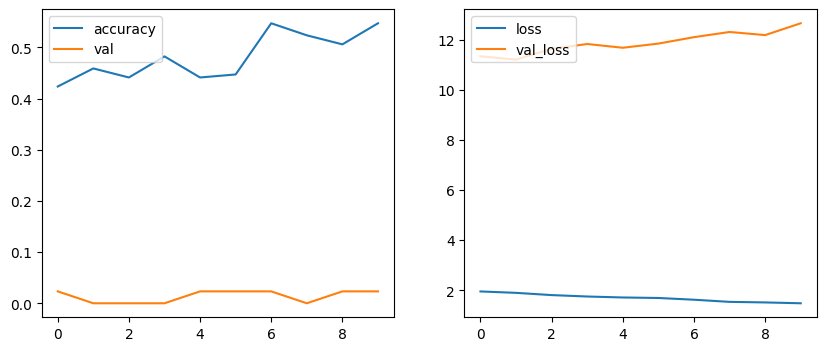

In [74]:
train()

### prediction

In [80]:

def pred(words,lenght=100):
    word_arr = list(words.split())
    indexs = [word_index.index(w.lower()) for w in word_arr ]
    vec = np.array(indexs).reshape(1,3,1)
    prd = np.argmax(model.predict(vec,verbose=0))
    prd = word_index[prd] 
    
    
    return prd

In [82]:

cnt = 0
arr = ["my","name",'is']
print(arr[0],arr[1],end=" ")
while cnt<100:
    prd = pred(" ".join(arr))
    arr[0] = arr[1]
    arr[1] = prd
    cnt +=1
    print(prd,end=" ")

my name it good you i that it but dinner with know sounds they me , they suggest , over cake suggest silly hear last go i <unk> it us us . . good to thats with idea sounds hear fun go . <unk> to with with sounds sounds me me they they , , after suggest i our it thats you idea that hear with go sounds <unk> me are they shall , ? suggest that over with cake dinner know know tempting tempting and and too of s . . good to thats with idea sounds hear fun go . 

### Note : 
This model requires a large amount of data to function as expected. It is intended for learning purposes only.
